<a href="https://colab.research.google.com/github/choderalab/pinot/blob/master/scripts/adlala_mol_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [0]:
! rm -rf pinot
! git clone https://github.com/choderalab/pinot.git

Cloning into 'pinot'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 859 (delta 66), reused 80 (delta 14), pack-reused 692
Receiving objects: 100% (859/859), 154.69 MiB | 31.58 MiB/s, done.
Resolving deltas: 100% (297/297), done.
Checking out files: 100% (503/503), done.


In [0]:
! pip install dgl
! wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
! chmod +x Miniconda3-latest-Linux-x86_64.sh
! time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
! time conda install -q -y -c conda-forge rdkit

     |████████████████████████████████| 3.0MB 2.8MB/s 
--2020-04-28 22:29:09--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-04-28 22:29:10--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   190MB/s    in 0.4s    

20

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
sys.path.append('/content/pinot/')

# data



In [0]:
import pinot
dir(pinot)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


['Net',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'app',
 'data',
 'graph',
 'inference',
 'metrics',
 'net',
 'pinot',
 'regression',
 'representation']

In [0]:
ds = pinot.data.esol()
ds = pinot.data.utils.batch(ds, 32)

In [0]:
ds_tr, ds_te = pinot.data.utils.split(ds, [4, 1])

# network

In [0]:
net = pinot.representation.Sequential(
    lambda in_feat, out_feat: pinot.representation.dgl_legacy.GN(in_feat, out_feat, 'SAGEConv'),
    [32, 'tanh', 32, 'tanh', 32, 'tanh', 1])

# Adam

In [0]:
import torch
import numpy as np
opt = torch.optim.Adam(net.parameters(), 1e-3)
loss_fn = torch.nn.functional.mse_loss

In [0]:
rmse_tr = []
rmse_te = []
for _ in range(100):
    for g, y in ds_tr:
        opt.zero_grad()
        y_hat = net(g)
        loss = loss_fn(y, y_hat)
        loss.backward()
        opt.step()

    rmse_tr.append(np.mean([np.sqrt(loss_fn(y, net(g)).detach().numpy()) for g, y in ds_tr]))
    rmse_te.append(np.mean([np.sqrt(loss_fn(y, net(g)).detach().numpy()) for g, y in ds_te]))



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size 

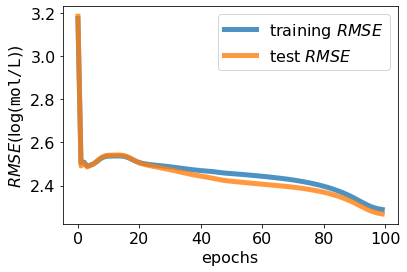

In [0]:
import matplotlib
from matplotlib import pyplot as plt
plt.rc('font', size=16) 
plt.plot(rmse_tr, label='training $RMSE$', linewidth=5, alpha=0.8)
plt.plot(rmse_te, label='test $RMSE$', linewidth=5, alpha=0.8)
plt.xlabel('epochs')
plt.ylabel('$RMSE (\log (\mathtt{mol/L}))$')
plt.legend()

# Langevin

In [0]:
net = pinot.representation.Sequential(
    lambda in_feat, out_feat: pinot.representation.dgl_legacy.GN(in_feat, out_feat, 'SAGEConv'),
    [32, 'tanh', 32, 'tanh', 32, 'tanh', 1])

In [0]:
opt = pinot.inference.adlala.AdLaLa(net.parameters(), partition='La', h=1e-3)

In [0]:
rmse_tr = []
rmse_te = []
for _ in range(100):
    for g, y in ds_tr:
        def l():
            opt.zero_grad()
            y_hat = net(g)
            loss = loss_fn(y, y_hat)
            loss.backward()
            print(loss)
            return loss
        opt.step(l)

    rmse_tr.append(np.mean([np.sqrt(loss_fn(y, net(g)).detach().numpy()) for g, y in ds_tr]))
    rmse_te.append(np.mean([np.sqrt(loss_fn(y, net(g)).detach().numpy()) for g, y in ds_te]))



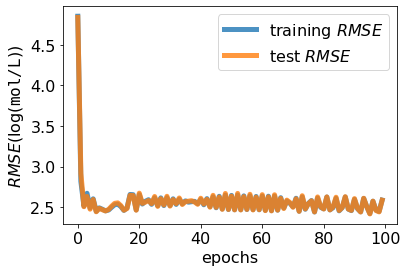

In [0]:
import matplotlib
from matplotlib import pyplot as plt
plt.rc('font', size=16) 
plt.plot(rmse_tr, label='training $RMSE$', linewidth=5, alpha=0.8)
plt.plot(rmse_te, label='test $RMSE$', linewidth=5, alpha=0.8)
plt.xlabel('epochs')
plt.ylabel('$RMSE (\log (\mathtt{mol/L}))$')
plt.legend()

# Adaptive Langevin

In [0]:
net = pinot.representation.Sequential(
    lambda in_feat, out_feat: pinot.representation.dgl_legacy.GN(in_feat, out_feat, 'SAGEConv'),
    [32, 'tanh', 32, 'tanh', 32, 'tanh', 1])

In [0]:
opt = pinot.inference.adlala.AdLaLa(net.parameters(), partition='AdLa', h=1e-3)

In [0]:
rmse_tr = []
rmse_te = []
for _ in range(100):
    for g, y in ds_tr:
        def l():
            opt.zero_grad()
            y_hat = net(g)
            loss = loss_fn(y, y_hat)
            loss.backward()
            print(loss)
            return loss
        opt.step(l)

    rmse_tr.append(np.mean([np.sqrt(loss_fn(y, net(g)).detach().numpy()) for g, y in ds_tr]))
    rmse_te.append(np.mean([np.sqrt(loss_fn(y, net(g)).detach().numpy()) for g, y in ds_te]))



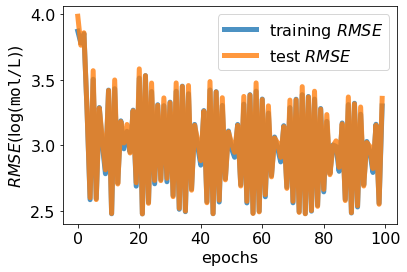

In [0]:
import matplotlib
from matplotlib import pyplot as plt
plt.rc('font', size=16) 
plt.plot(rmse_tr, label='training $RMSE$', linewidth=5, alpha=0.8)
plt.plot(rmse_te, label='test $RMSE$', linewidth=5, alpha=0.8)
plt.xlabel('epochs')
plt.ylabel('$RMSE (\log (\mathtt{mol/L}))$')
plt.legend()

# AdLaLa: AdLa for GN, La for last layer

In [0]:
net = pinot.representation.Sequential(
    lambda in_feat, out_feat: pinot.representation.dgl_legacy.GN(in_feat, out_feat, 'SAGEConv'),
    [32, 'tanh', 32, 'tanh', 32, 'tanh', 1])

In [0]:
net

Sequential(
  (f_in): Sequential(
    (0): Linear(in_features=117, out_features=128, bias=True)
    (1): Tanh()
  )
  (d0): GN(
    (gn): SAGEConv(
      (feat_drop): Dropout(p=0.0, inplace=False)
      (fc_self): Linear(in_features=128, out_features=32, bias=True)
      (fc_neigh): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (d2): GN(
    (gn): SAGEConv(
      (feat_drop): Dropout(p=0.0, inplace=False)
      (fc_self): Linear(in_features=32, out_features=32, bias=True)
      (fc_neigh): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (d4): GN(
    (gn): SAGEConv(
      (feat_drop): Dropout(p=0.0, inplace=False)
      (fc_self): Linear(in_features=32, out_features=32, bias=True)
      (fc_neigh): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (d6): GN(
    (gn): SAGEConv(
      (feat_drop): Dropout(p=0.0, inplace=False)
      (fc_self): Linear(in_features=32, out_features=1, bias=True)
      (fc_neigh): Linear(in_features=32, out_featu

In [0]:
opt = pinot.inference.adlala.AdLaLa(
    [
        {'params': list(net.f_in.parameters())\
       + list(net.d0.parameters())\
       + list(net.d2.parameters())\
       + list(net.d4.parameters()), 'partition': 'AdLa', 'h': torch.tensor(1e-3)},
     {
         'params': list(net.d6.parameters()) + list(net.f_out.parameters()),
      'partition': 'La', 'h': torch.tensor(1e-3)
     }
    ])


In [0]:
rmse_tr = []
rmse_te = []
for _ in range(100):
    for g, y in ds_tr:
        def l():
            opt.zero_grad()
            y_hat = net(g)
            loss = loss_fn(y, y_hat)
            loss.backward()
            print(loss)
            return loss
        opt.step(l)

    rmse_tr.append(np.mean([np.sqrt(loss_fn(y, net(g)).detach().numpy()) for g, y in ds_tr]))
    rmse_te.append(np.mean([np.sqrt(loss_fn(y, net(g)).detach().numpy()) for g, y in ds_te]))



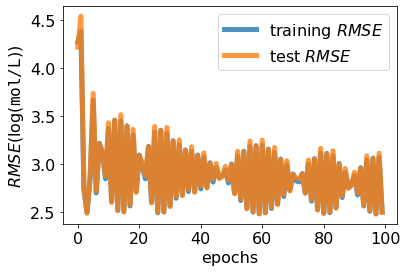

In [0]:
import matplotlib
from matplotlib import pyplot as plt
plt.rc('font', size=16) 
plt.plot(rmse_tr, label='training $RMSE$', linewidth=5, alpha=0.8)
plt.plot(rmse_te, label='test $RMSE$', linewidth=5, alpha=0.8)
plt.xlabel('epochs')
plt.ylabel('$RMSE (\log (\mathtt{mol/L}))$')
plt.legend()